In [1]:
from mot_analysis.motimg import MOTImaging
# blue mot tof flight measurement
import os
import glob
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Import and fit the 2D gaussian width

[154.69851985836246, 163.75279351984975, 174.5635644256205, 188.6904778403138, 203.80204709882383, 219.2609766361944, 234.20254246354227, 250.56038535608508, 265.22130538440763, 276.91659645392787]
[317.13313589757894, 318.5412588620627, 318.66702862548857, 324.92663337512244, 329.095310243639, 335.7723159717075, 336.0668214034113, 336.7286114867813, 325.5275837734142, 319.30424652873904]


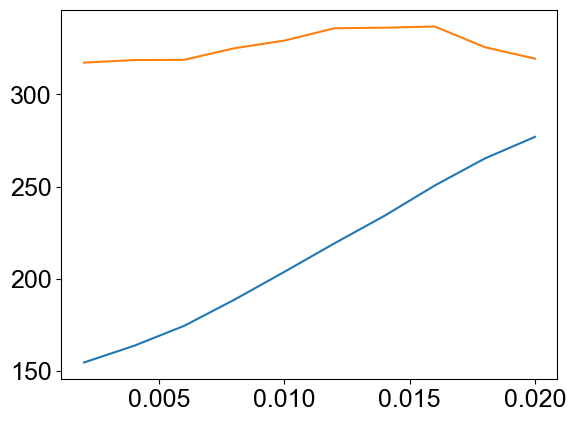

In [96]:
folder_path = r"Z:\AION\Data\2024\12\06\nb_tof_347p34"

# Get a list of all HDF5 files in the directory
h5_files = glob.glob(os.path.join(folder_path, '*.h5'))

# Sort files by modification time to ensure they are in the correct order
h5_files.sort(key=os.path.getmtime)

horiz_data_list = []
vert_data_list = []
time_of_flights = []

# Iterate over each HDF5 file and extract data
for file_path in h5_files:
    with h5py.File(file_path, 'r') as f:
        mot_tof_data_horiz = f['horizontal camera red mot'][:]
        mot_tof_data_vert = f['vertical camera red mot'][:]
        parameters = json.loads(f['parameters'][()])
        time_of_flight = parameters["sequence_parameters"]["time_of_flight"]
    if np.sum(mot_tof_data_horiz) > 1e5 or np.sum(mot_tof_data_vert) > 1e5:
        horiz_data_list.append(mot_tof_data_horiz)
        vert_data_list.append(mot_tof_data_vert)
        time_of_flights.append(time_of_flight)

# Sort the lists by the order of the time_of_flights list
sorted_lists = sorted(zip(time_of_flights, horiz_data_list, vert_data_list))
time_of_flights, horiz_data_list, vert_data_list = zip(*sorted_lists)

#time_of_flights = time_of_flights[:10]
# Convert back to lists
time_of_flights = list(time_of_flights)
horiz_data_list = list(horiz_data_list)
vert_data_list = list(vert_data_list)
gaussian_widths_horiz = []
gaussian_widths_vert = []

#for i in range(10):
for i in range(len(horiz_data_list)):
    mot_imaging_horiz = MOTImaging(horiz_data_list[i])
    gaussian_width_horiz = abs(mot_imaging_horiz.fit_2d_gaussian()[3])
    mot_imaging_vert = MOTImaging(vert_data_list[i])
    gaussian_width_vert = abs(mot_imaging_vert.fit_2d_gaussian()[3])

    gaussian_widths_horiz.append(gaussian_width_horiz)
    gaussian_widths_vert.append(gaussian_width_vert)

plt.plot(time_of_flights, gaussian_widths_horiz, label='Horizontal')    
plt.plot(time_of_flights, gaussian_widths_vert, label='Vertical')
print(gaussian_widths_horiz)
print(gaussian_widths_vert)
    
    

# Save the data calculated in the previous step

In [97]:
time_of_flights_store = time_of_flights
gaussian_widths_horiz_store = gaussian_widths_horiz
gaussian_widths_vert_store = gaussian_widths_vert
# store the data
# Get the current datetime
now = datetime.datetime.now()
# Format the datetime as a string
datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")
saving_name = "data/"+ datetime_string + "_mot_data.npz"
np.savez(saving_name, time_of_flights=time_of_flights_store, gaussian_widths_horiz=gaussian_widths_horiz_store, gaussian_widths_vert=gaussian_widths_vert_store)

In [98]:
# load the data
data = np.load(saving_name)
time_of_flights = data['time_of_flights']
gaussian_widths_horiz = data['gaussian_widths_horiz']
gaussian_widths_vert = data['gaussian_widths_vert']
time_of_flights_store = time_of_flights
gaussian_widths_horiz_store = gaussian_widths_horiz
gaussian_widths_vert_store = gaussian_widths_vert

# Fit the Horizontal data

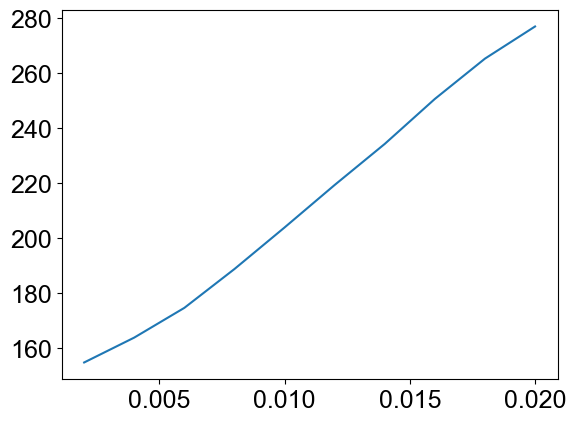

In [99]:
# exclude the points that are too big in gaussian_widths_horiz and update time_of flights
# find the index of the elements that are bigger than 2000 in gaussian_widths_horiz
index = [i for i, x in enumerate(gaussian_widths_horiz) if abs(x) >= 1000]
gaussian_widths_horiz = [x for x in gaussian_widths_horiz if abs(x) < 1000]
time_of_flights = [x for i, x in enumerate(time_of_flights) if i not in index]
plt.plot(time_of_flights, gaussian_widths_horiz, label='Horizontal')    

In [100]:

def set_plotting_style():
    plt.rc("font", family = 'Arial', size=10)
    plt.rc('axes', labelsize=20, titlesize = 20, labelpad=5)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('legend', fontsize=15)

set_plotting_style()

temperature:5.05910082597464e-05
r0:0.0019295628466446187


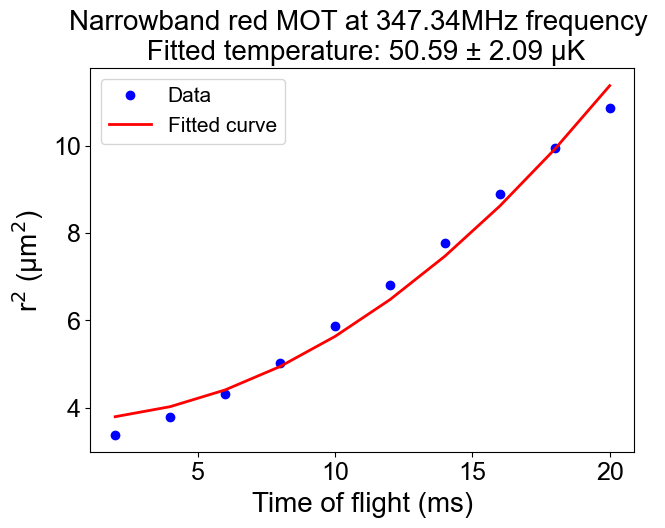

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants
Mass = 88*1.66e-27 # mass of Sr
K_B = 1.38e-23  # Boltzmann constant

# Sample data (replace with your actual data)
time_of_flights = time_of_flights # example time of flights
gaussian_widths_horiz = gaussian_widths_horiz # example gaussian widths

t = np.array(time_of_flights) 
rsquares = (np.array(gaussian_widths_horiz)*3.45e-6/0.58*2)**2

# t = np.delete(t, 6)
# rsquares = np.delete(rsquares, 6)
# t = np.delete(t, 0)
# rsquares = np.delete(rsquares, 0)

# Define the fitting function
# 4kBt^2 = m(r(t)^2 - r0^2)
def fitting_function(t, gradient, b):
    return gradient * t**2 + b

# Perform the curve fitting
params, covariance = curve_fit(fitting_function, t, rsquares)

# Extract the fitted parameters
gradient_fit, b_fit = params
temperature = gradient_fit * Mass / (4 * K_B)
r0 = np.sqrt(b_fit)
print(f'temperature:{temperature}')
print(f'r0:{r0}')
# Generate fitted data
fitted_rsquares = fitting_function(t, gradient_fit, b_fit)

gradient_fit_uncertainty = np.sqrt(covariance[0, 0])

# Calculate the uncertainty of the temperature
temperature_uncertainty = gradient_fit_uncertainty * Mass / (4 * K_B)


# Plot the original data and the fitted curve

# plt.figure(figsize=(12, 10))
plt.plot(t*1e3, rsquares * 1e6, 'bo', label='Data')
plt.plot(t*1e3, fitted_rsquares * 1e6, 'r-', linewidth = 2, label='Fitted curve')
plt.title(f'Narrowband red MOT at 347.34MHz frequency \n Fitted temperature: {temperature*1e6:.2f} ± {temperature_uncertainty*1e6:.2f} μK')
plt.xlabel('Time of flight (ms)')
plt.ylabel(r'r$^2$ (μm$^2$)')
plt.legend()
plt.tight_layout()
# plt.show()



plt.subplots_adjust(left=0.15, right=1.0, top=0.9, bottom=0.1)

plt.savefig('241206 Narrowband red MOT ToF 347pt34MHz.pdf', dpi=1200, bbox_inches='tight')

In [12]:
time_of_flights[9:]

[]

# Vertical Data

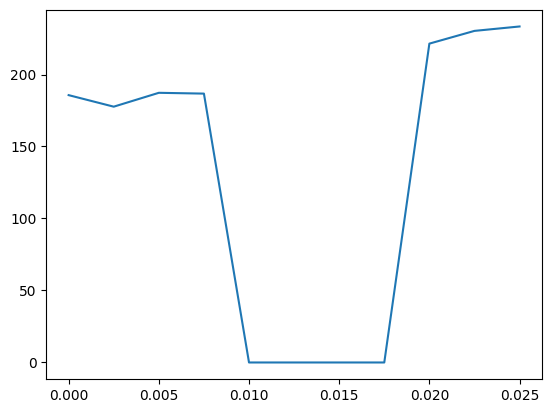

In [34]:
# exclude the points that are too big in gaussian_widths_horiz and update time_of flights
# find the index of the elements that are bigger than 2000 in gaussian_widths_horiz
index = [i for i, x in enumerate(gaussian_widths_vert_store) if abs(x) >= 2000]
gaussian_widths_vert = [x for x in gaussian_widths_vert_store if abs(x) < 2000]
time_of_flights = [x for i, x in enumerate(time_of_flights_store) if i not in index]
plt.plot(time_of_flights, gaussian_widths_vert, label='vertical')    

-0.7986085821313298
0.0024978793287335943


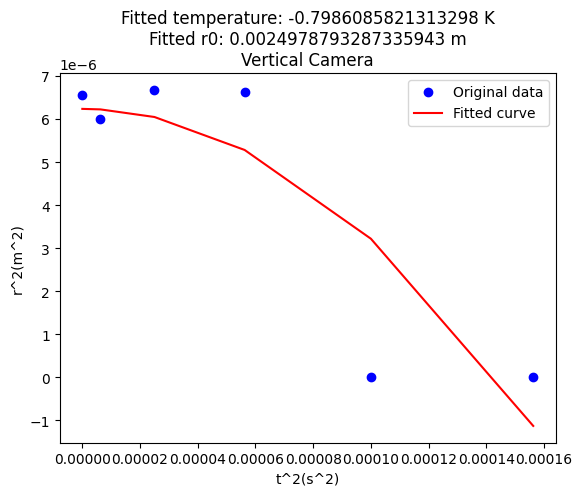

In [35]:
# do fitting for vertical
gaussian_widths_vert = gaussian_widths_vert[:-5]
time_of_flights = time_of_flights[:-5]
tsquares = np.array(time_of_flights)**2
rsquares = (np.array(gaussian_widths_vert)*3.45e-6/0.5*2)**2
params, covariance = curve_fit(fitting_function, tsquares, rsquares)
gradient_fit, b_fit = params
temperature = gradient_fit * Mass / (4 * K_B)
r0 = np.sqrt(b_fit)
print(temperature)
print(r0)
# Generate fitted data
fitted_rsquares = fitting_function(tsquares, gradient_fit, b_fit)

# Plot the original data and the fitted curve
plt.plot(tsquares, rsquares, 'bo', label='Original data')
plt.plot(tsquares, fitted_rsquares, 'r-', label='Fitted curve')
plt.title(f'Fitted temperature: {temperature} K'+
          f'\nFitted r0: {r0} m'
          f'\nVertical Camera')
plt.xlabel('t^2(s^2)')
plt.ylabel('r^2(m^2)')
plt.legend()
plt.show()
